# Assignment 8 - Language Translation (English - Hindi)

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import string
from string import digits
import tensorflow as tf
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import time

## Read language text files

In [2]:
df = pd.read_csv('hind-eng_df.csv')

In [3]:
df['hindi']=df['hindi'].replace('।','',regex=True)

In [8]:
df=df[['hindi','english']]

In [10]:
df.head()

,hindi,english
0,वाह,wow
1,बचाओ,help
2,उछलो,jump
3,कूदो,jump
4,छलांग,jump


In [11]:
df.tail()

,hindi,english
2862,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...,the passengers who were injured in the acciden...
2863,लोकतंत्र सरकार का सबसे घिनौना रूप है COMMA अगर...,democracy is the worst form of government COMM...
2864,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...,if my boy had not been killed in the traffic a...
2865,जब मैं बच्चा था COMMA मुझे कीड़ों को छूने से क...,when i was a kid COMMA touching bugs didnt bot...
2866,आप जिस वाक्य का अनुवाद कर रहे हैं COMMA उस ही ...,make a good translation of the sentence that y...


## Preprocess text

##### Filter to only keep sentences with word counts between 5 to 100 words

In [12]:
df_preprocessed = df[['english','hindi']].rename(columns={'english':'English','hindi':'Hindi'})

In [14]:
# Filter the DataFrame to only keep sentences with word counts between 5 to 100 words
filtered_df_by_word_count = df_preprocessed[
    (df_preprocessed['English'].str.split().str.len() >= 5) &
    (df_preprocessed['English'].str.split().str.len() <= 100) &
    (df_preprocessed['Hindi'].str.split().str.len() >= 5) &
    (df_preprocessed['Hindi'].str.split().str.len() <= 100)
]

In [15]:
filtered_df_by_word_count.reset_index(drop=True, inplace=True)

In [16]:
filtered_df_by_word_count.head()

,English,Hindi
0,he has a hat on,उसने टोपी पहनी हुई है
1,no COMMA i didnt go,नहीं COMMA मैं नहीं गया था
2,he came to see me,वह मुझसे मिलने आया था
3,he is after a job,वह किसी नौकरी के पीछे पड़ा है
4,i can drive a car,मैं गाड़ी चला सकता हूँ


In [17]:
lines = filtered_df_by_word_count

## Tokenize the data
##### Adding start and end tokens

In [19]:
def preprocess_sentence(w):
    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

##### In Transformer, we add beginning and end of sentence sentinels to *both* languages:

In [20]:
def create_full_dataset():
    sentence_pairs = [[preprocess_sentence(l[0]), preprocess_sentence(l[1])] for l in lines.values]
    return zip(*sentence_pairs)

In [21]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, lang_tokenizer

In [22]:
def load_full_dataset():
    # creating cleaned input, output pairs
    inp_lang, targ_lang = create_full_dataset()

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [23]:
en, hi = create_full_dataset()
print(en[0])
print(hi[0])

<start> he has a hat on <end>
<start> उसने टोपी पहनी हुई है <end>


In [24]:
num_examples = len(lines)
input_tensor, target_tensor, inp_lang, targ_lang = load_full_dataset()

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(29, 25)

In [25]:
# Function to print vocabulary words
def print_vocab_words(tokenizer, language_name, num_words=10):
    # Extract the word_index from the tokenizer
    word_index = tokenizer.word_index

    # Get the first 'num_words' words from the vocabulary
    first_words = list(word_index.keys())[:num_words]

    print(f"First {num_words} words in the {language_name} vocabulary:")
    for word in first_words:
        print(word)

# 'inp_lang' and 'targ_lang' are tokenizer objects for input and target languages, respectively
print_vocab_words(inp_lang, "Input Language")
print_vocab_words(targ_lang, "Target Language")

First 10 words in the Input Language vocabulary:
<start>
<end>
the
to
i
you
a
is
he
of
First 10 words in the Target Language vocabulary:
<start>
<end>
है
में
नहीं
वह
से
मैं
के
को


In [26]:
# Vocabulary size for the input language
input_vocab_size = len(inp_lang.word_index) + 1  # Adding 1 because indexing starts from 1
print(f"Input language vocabulary size: {input_vocab_size}")

# Vocabulary size for the target language
target_vocab_size = len(targ_lang.word_index) + 1  # Adding 1 because indexing starts from 1
print(f"Target language vocabulary size: {target_vocab_size}")

Input language vocabulary size: 2156
Target language vocabulary size: 2556


In [27]:
# Creating training and validation sets using an 90-10 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.1)

input_tensor_train.shape, input_tensor_val.shape, target_tensor_train.shape, target_tensor_val.shape

((1881, 25), (209, 25), (1881, 29), (209, 29))

In [28]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [29]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[1])

Input Language; index to word mapping
1 ----> <start>
9 ----> he
8 ----> is
508 ----> getting
425 ----> along
34 ----> with
22 ----> his
1680 ----> employees
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
6 ----> वह
35 ----> अपने
638 ----> कर्मचारियों
9 ----> के
64 ----> साथ
283 ----> अच्छे
7 ----> से
2013 ----> निभता
3 ----> है
2 ----> <end>


In [30]:
BATCH_SIZE = 16
BUFFER_SIZE = len(input_tensor_train)

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset_train = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

2024-04-06 19:04:31.177625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-06 19:04:31.177703: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-06 19:04:31.177723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-06 19:04:31.178008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-06 19:04:31.178379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
train_dataset = dataset_train
val_dataset = dataset_val

## Positional encoding

In [32]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [33]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## Masking pad tokens in the input and future tokens in the output

In [34]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [35]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [36]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Multi-head attention

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## Pointwise feed forward network

In [38]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

# Encoder and decoder

Now we're ready to talk about the encoder and decoder. In that, the transformer model follows the same general pattern as our standard sequence to sequence with attention model, albeit with multiple layers:

* The input sentence is passed through `N` encoder layers that generate an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.

## Encoder layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask)
2. Pointwise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

## Decoder layer

Each decoder layer consists of sublayers:

1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask): V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3. Pointwise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## Encoder

And now we can talk about the encoder.

The `Encoder` consists of:
1.   Word2vec semantic embedding
2.   Positional Encoding
3.   N encoder layers (what we coded above)

The input is fed through an embedding which is then summed with  positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [41]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

## Decoder

 The `Decoder` consists of:
1.   Word2vec embedding of the target sequence
2.   Positional Encoding
3.   N decoder layers

The target sequence is fed through an embedding and summed with positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to our final linear layer, which we mention in the wrapper Transformer layer.

In [42]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## Create the Transformer

Transformer consists of the encoder, decoder and our final affine (linear) `Dense` layer. The output of the decoder is the input to the linear layer and its output is returned.

In [43]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

### Hyperparameters

In [44]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = len(inp_lang.word_index) + 1
target_vocab_size = len(targ_lang.word_index) + 1
dropout_rate = 0.1

## Optimizer

In [45]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

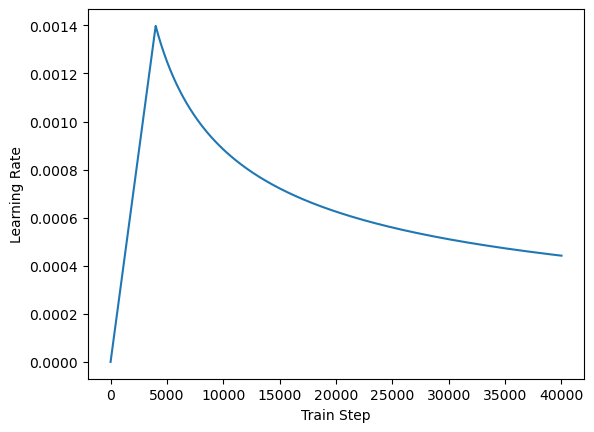

In [47]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [48]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [49]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [51]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [52]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

Create the `transformer` folder in your `~/data/training_checkpoints` folder.

In [53]:
checkpoint_path = "training_checkpoints/transformer"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into `tar_inp` and `tar_real`. `tar_inp` is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "<start> A lion in the jungle is sleeping <end>"

`tar_inp` =  `<start> A lion in the jungle is sleeping`

`tar_real` = `A lion in the jungle is sleeping <end>`

The transformer is an auto-regressive model: it makes predictions one word at a time, and uses its output so far to decide what word to predict next.

During training, this example uses teacher-forcing

(as in the [text generation tutorial](./text_generation.ipynb)).

Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, **self-attention** allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output, the model uses a look-ahead mask.

This is our training step:

In [116]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

# for our corpus
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

## We'll be running translations inline as we're training the transformer.

In [117]:
EPOCHS = 1

In [118]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                train_loss.result(),
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    # try a translation to see where we at
    try:
        translate(None, plot=True)
    except Exception:
        continue

2024-04-06 19:18:59.843626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1 Batch 0 Loss 1.3885 Accuracy 0.2723
Epoch 1 Batch 50 Loss 2.2436 Accuracy 0.1827
Epoch 1 Batch 100 Loss 2.1769 Accuracy 0.1874
Epoch 1 Loss 2.1263 Accuracy 0.1910
Time taken for 1 epoch: 22.291985273361206 secs

[1, 1, 246, 272, 7, 527, 324, 2, 2]
Input: <start> thats really a great idea <end>
Predicted translation: ['<start> वह अच्छा कमा लेता है']


<Figure size 1600x800 with 0 Axes>

## Model evaluation

The following steps are used for evaluation:

* Encode the input sentence using our chinese tokenizer (`tokenizer_zh`). Moreover, add the start and end sentinel tokens so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the original Transformer paper, use the entire dataset and base transformer model or transformer XL, by changing our hyperparameters above.

In [63]:
def evaluate(inp_sentence):

    inp_sentence = [targ_lang.word_index['<start>']] + inp_sentence[0] + [targ_lang.word_index['<end>']]
    print(inp_sentence)
    encoder_input = tf.expand_dims(inp_sentence, 0)

    #decoder_input = [tokenizer_en.vocab_size]
    decoder_input = [targ_lang.word_index['<start>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang.word_index['<end>']:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [76]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = inp_lang.texts_to_sequences([sentence])

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        xticks = ['<start>']
        words = [inp_lang.sequences_to_texts([i]) for i in sentence]
        xticks.extend(words[0][0].split(' '))
        xticks.append('<end>')
        print('xticks:',xticks)
        ax.set_xticklabels(
            xticks,
            fontdict=fontdict, rotation=90)


        print(result.numpy())
        twords = [targ_lang.sequences_to_texts([result.numpy()])]
        print(twords)
        twords = twords[0][0].split(' ')
        pwords = pinyin_jyutping_sentence.pinyin(' '.join(twords[1:]))
        print(pwords)
        yticks = [] #['<start>']
        yticks.extend(pwords.split(' '))
        yticks = [t for t in yticks if t]
        print('yticks:',yticks)

        ax.set_yticklabels(yticks,
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()

In [71]:
sentence = inp_lang.texts_to_sequences(["i will go there"])
xticks = ['<start>']
words = [inp_lang.sequences_to_texts([i]) for i in sentence]
xticks.extend(words[0][0].split(' '))
xticks.append('<end>')
xticks

['<start>', 'i', 'will', 'go', 'there', '<end>']

In [72]:
sentence = en[np.random.choice(len(en))]
print(sentence)
sentence_seq = inp_lang.texts_to_sequences([sentence])
print(sentence_seq)

<start> all the students look up to him <end>
[[1, 41, 3, 547, 536, 45, 4, 28, 2]]


In [110]:
def translate(sentence=None, plot=''):
    if sentence is None:
        sentence = en[np.random.choice(len(en))]
    sentence_seq = inp_lang.texts_to_sequences([sentence])
    result, attention_weights = evaluate(sentence_seq)

    predicted_sentence = targ_lang.sequences_to_texts([result.numpy()])
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [112]:
translate("i want to clean the house before my parents return")

[1, 5, 59, 4, 354, 3, 113, 140, 13, 290, 544, 2]
Input: i want to clean the house before my parents return
Predicted translation: ['<start> मैं अपने पापामम्मी के वापस आने से पहले घर साफ़ करना चाहता हूँ']


In [113]:
translate("the man who is standing there is my father")

[1, 3, 86, 126, 8, 428, 43, 8, 13, 67, 2]
Input: the man who is standing there is my father
Predicted translation: ['<start> वहाँ पर खड़े हुए वे मेरे पिता हैं']


In [114]:
translate("i like watching tv after dinner")

[1, 5, 35, 368, 318, 209, 333, 2]
Input: i like watching tv after dinner
Predicted translation: ['<start> मुझे रात को खाना खाने के बाद क्या करते हो']
